In [2]:
# check which kernel we are using
!which python

/home/quirin/anaconda3/envs/skl/bin/python


## First steps

When it is online, [ProThermDB](https://web.iitm.ac.in/bioinfo2/prothermdb/index.html) can be scraped as a `31.526×42` table of `38.8MB` as a `.TSV` table if you (*e.g.*) request all entries matching `pH = 0:14`. 
[MPTherm](https://www.iitm.ac.in/bioinfo/mptherm/search.php) is smaller, containing `7202(×42)` records. It returns the entire database for `Organism = ' '`.

Maria prepared two datasets (*$\rightarrow$ full set* and *$\rightarrow$ redundancy-reduced set*) for three different measurements already: 

> $\Delta T_{m}$: change in melting temperature
>
> $\Delta\Delta G$: change in Gibbs Free energy of the protein, i.e. energy necessary to unfold the structure. 
>> "*If ddG is positive, the mutated protein is less stable than the wild type, which means a higher likelihood of a loss of function in the mutant; conversely, a negative ddG suggests that the structure is more stable pointing to the possibility of overstabilisation, i.e. preventing biologically relevant conformational changes.*" Zaucha et al. 2020
>>
>> $-1.0 \leq \Delta\Delta G \leq 1.0$ are 'neutral' variants, which only subtly perturb the protein structure
>>
>> $[kcal/mol]$
>
> $\Delta\Delta G_{H_{2}O}$: change in Free Energy for unfolding in water

I got six `.FASTA` files (two per measurement and three per dataset) with protein sequence data and header annotations in canonical UniPort format, as well as three per-measurement `.TSV` files of annotations.

First, try BioPython and RegEx parsing of `.FASTA` headers.

In [3]:
from Bio import SeqIO
from pathlib import Path
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import numpy as np

In [4]:
wd = Path('.').resolve().parent
for fasta in wd.rglob('*.fasta'):
    for record in SeqIO.parse(fasta, 'fasta'):
#        pass
        print(record.description)
        break
    break
    
record.seq

P02625


Seq('MSMTDLLSAEDIKKAIGAFTAADSFDHKKFFQMVGLKKKSADDVKKVFHILDKD...AES')

In [5]:
!find .. -name '*.fasta'

../all_sequences_prothermdb.fasta
../reduced_set/uniprot_prothermdb_melttemp_rep_seq.fasta
../reduced_set/uniprot_prothermdb_delta_g_rep_seq.fasta
../reduced_set/uniprot_prothermdb_delta_g_h2o_rep_seq.fasta
../full_set/uniprot_prothermdb_delta_g.fasta
../full_set/uniprot_prothermdb_melttemp.fasta
../full_set/uniprot_prothermdb_delta_g_h2o.fasta


In [6]:
!cat ../**/*.fasta | grep ">" > headers.txt
!head headers.txt

>P02625
>P02625_27A
>P02625_22P_81S
>P02625_81S
>P02625_22P_27P
>P02625_27P
>P02625_22P
>P02625_22A_27A
>P00711
>P00711_51Y


Testing the RegEx at https://regex101.com/r/wnT73m/3

In [7]:
regex = re.compile('(?P<db>(?:sp|tr))\|(?P<accession>.+?)\|(?P<name>\S+?) (?P<full_name>.+?) OS=(?P<organism>.+?) OX=(?P<taxon_id>.+?) (GN=(?P<gene>.+?) )?PE=(?P<evidence_level>.+?) SV=(?P<version>.+?)$')
regex

re.compile(r'(?P<db>(?:sp|tr))\|(?P<accession>.+?)\|(?P<name>\S+?) (?P<full_name>.+?) OS=(?P<organism>.+?) OX=(?P<taxon_id>.+?) (GN=(?P<gene>.+?) )?PE=(?P<evidence_level>.+?) SV=(?P<version>.+?)$',
re.UNICODE)

In [27]:
i = 0
for fasta in wd.rglob('*.fasta'):
    if i == 0:
        i = 1
        continue
    for record in SeqIO.parse(fasta, 'fasta'):
        break
    break
    
print(record.description)
m = regex.match(record.description)
print(m)

P02689
None


In [26]:
m.groupdict()

AttributeError: 'NoneType' object has no attribute 'groupdict'

In [10]:
record.annotations = m.groupdict()
print(record)
dir(record.seq)

AttributeError: 'NoneType' object has no attribute 'groupdict'

Try out path regex here https://regex101.com/r/zjRWrx/1

In [11]:
path_regex = re.compile(r'.*?_prothermdb_(?P<measure>.+?)(?:(?:_)?(?P<dataset>rep_seq|a?)?\.fasta|\.tsv)')
path_regex

re.compile(r'.*?_prothermdb_(?P<measure>.+?)(?:(?:_)?(?P<dataset>rep_seq|a?)?\.fasta|\.tsv)',
re.UNICODE)

In [12]:

for ext in ['fasta', 'tsv']:
    for file in wd.rglob('*.%s' % ext):
        match = path_regex.match(file.name)
        assert match
        print(match.groupdict())


AssertionError: 

In [13]:
seq_data = dict()

for fasta in wd.rglob('*.fasta'):
    gd = path_regex.match(fasta.name).groupdict()
    assert gd
    key = 'full' if not gd['dataset'] else gd['dataset'] , gd['measure']
    
    seq_data[key] = dict()
    for record in SeqIO.parse(fasta, 'fasta'):
        m = regex.match(record.description)
        assert m
        record.annotations = m.groupdict()
        record.id = record.annotations['accession']  # use the UniProt accession as id, as in ProtTherm
        
        assert record.id not in seq_data[key], '%s already observed\n' % record.id
        seq_data[key][record.id] = record

AttributeError: 'NoneType' object has no attribute 'groupdict'

In [14]:
{str(fasta): len(d) for fasta, d in seq_data.items()}

{}

In [15]:
keys = sorted(seq_data.keys())
keys

[]

Let's check whether the sequence data contains mutations

In [16]:
for i, j in zip([0,1,2], [3,4,5]):
    full = seq_data[keys[i]]
    partial = seq_data[keys[j]]
    shared = set(full.keys()).intersection(set(partial.keys()))
    assert all(full[_id].seq == partial[_id].seq for _id in shared)

IndexError: list index out of range

All the given `.FASTA` sequences are identical across conditions, *i.e.* do not contain mutations.

In [ ]:
dfs = {path_regex.match(tsv.name).groupdict()['measure']:
           pd.read_csv(tsv, sep='\t') for tsv in wd.rglob('*.tsv')}
dfs.keys()

In [ ]:
# run this cell until KeyError: 'popitem(): dictionary is empty' to ensure all dataframes are ok
path, df = dfs.popitem()
df

In [ ]:
path

In [ ]:
dfs = dict()
dfs = {path_regex.match(tsv.name).groupdict()['measure']:
           pd.read_csv(tsv, sep='\t') for tsv in wd.rglob('*.tsv')}

cols = lambda i: list(dfs[list(dfs.keys())[i]].columns)
assert cols(0) == cols(1) and cols(1) == cols(2), 'the dataframe colums are not identical'

conditions = list(dfs.keys())
for c in conditions:
    # pop to avoid pandas warnings
    df = dfs.pop(c)
    # filter out rows with undetermined '-' or 'wild-type' mutation
    df = df.loc[(df.MUTATION != '-') & (df.MUTATION != 'wild-type')]
    # split the mutation column'R191A K1943'
    df[['MUTATION', 'SOURCE']] = df.MUTATION.str.rstrip(')').str.split(' \(Based on ', expand=True)

    #print(df.loc[(df.SOURCE != 'UniProt') & (df.SOURCE != 'UniProt and PDB')])
    #break
    #df.loc[df.MUTATION.str.contains(':')
    
    # count mutations
    df['MUT_COUNT'] = df.MUTATION.str.strip().str.count(' ')+1
    dfs[c] = df
df = pd.concat(dfs.values(), keys=dfs.keys()).reset_index().rename(columns={'level_0': 'delta'})
df.loc[df.MUTATION.str.contains(':')]  # df.SOURCE == 'PDB']
df.loc[df.UniProt_ID == '-']
df

In [ ]:
print(df.SOURCE.unique())
df.loc[df.SOURCE == 'PDB']

In [ ]:
df.loc[df.UniProt_ID == '-']

In [ ]:
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
[m for m in df.MUTATION if ':' in m]

In [ ]:
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
[m for m in df.MUTATION if m[0] not in amino_acids]

---
### Counting numbers of mutations per line (= not per UniProt ID)

In [ ]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [ ]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']

for log in [True, False]:  
    g = sns.FacetGrid(data=df, col='delta', hue='delta', height=5, margin_titles=True, palette=cmap, 
                      col_order=order, hue_order=order[::-1])

    g.map_dataframe(sns.histplot, x='MUT_COUNT', log_scale=(False, log), discrete=True)
    g.set_axis_labels('mutation count','count frequency')
    g.set_titles(col_template='{col_name}')


    g.savefig(wd / 'plots' / 'barplot%s.png' % ('_log' if log else ''), dpi=300)

In [ ]:
cdf = df.groupby(['MUT_COUNT', 'delta'])['MUT_COUNT'].count().reset_index(name='freq')

sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)

g = sns.relplot(
    data=cdf, alpha=.9,
    x="MUT_COUNT", y="delta", 
    size="freq", hue="delta", 
    palette=cmap,
    sizes=(10, 1900),
    height=2.6, aspect=4.4,
    legend=False,
)

g.ax.xaxis.grid(True, "major", linewidth=1)
g.ax.yaxis.grid(True, "major", linewidth=.25)
g.ax.set_ylim(-1, 3)
g.despine(left=True, bottom=True)
g.set_axis_labels('mutation count per record, frequency as area', '')
#g.ax.set_yticklabels(['a','b','c'])
g.savefig(wd / 'plots' / 'dotplot.png', dpi=300)


---
### Comparing dataset sizes and share of redundant sequences

In [ ]:
records = [list(fasta) + [len(d)]  for fasta, d in seq_data.items()]
records

In [ ]:
dt = pd.DataFrame.from_records(records, columns=['set', 'measure', 'size'])
dt

In [ ]:
dt2 = dt.pivot(index='set', columns='measure', values='size').transpose()
dt2.full -= dt2.rep_seq
dt2.columns = ['redundant', 'unique']
dt2 = dt2.reindex(order)
avg = (sum(dt2.redundant) + sum(dt2.unique)) // 3
dt2

In [ ]:
import numpy as np
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)[::-1]
cmap[0] = adjust_lightness(cmap[0], 4)
vir = sns.color_palette('viridis', 2, as_cmap=False)

fig, ax = plt.subplots(1,3, figsize=(9,3))

ax = ax.flatten()
for i, cat in enumerate(dt2.index):
    dt2.loc[cat].plot.pie(ax=ax[i],
                          autopct='%1.f%%', counterclock=False,
                          labels=['redundant', 'unique'] if cat == 'melttemp' else ['', ''], 
                          startangle=0, 
                          radius=np.sqrt(sum(dt2.loc[cat]) / avg), 
                          colors=['lightgray', cmap[i]])
    ax[i].set_ylabel('')
    ax[i].set_title(cat, fontweight='bold', y=1.1)

#fig.suptitle('relative dataset size for different measurements and share of homologous samples')
fig.tight_layout()
fig.savefig('pies.png', dpi=300)

---
### Annotation Frequency / occurences per UniProt ID

In [ ]:
df

In [ ]:
uniprot = dict()
for row in df.itertuples():
    if row.delta not in uniprot:
        condition_dict = dict()
        uniprot[row.delta] = condition_dict
    else:
        condition_dict = uniprot[row.delta]
    if row.UniProt_ID in condition_dict:
        condition_dict[row.UniProt_ID] |= set(row.MUTATION.strip().split(' '))
    else:
        condition_dict[row.UniProt_ID] = set(row.MUTATION.strip().split(' '))
len(uniprot), sum(len(v) for v in uniprot.values()), max(len(v) for v in uniprot.values())

In [ ]:
for cond, cdict in uniprot.items():
    for _id, idict in cdict.items():
        cdict[_id] = len(idict)
#uniprot

In [ ]:
adf = pd.DataFrame.from_dict(uniprot, orient='index', dtype=int).fillna(0).convert_dtypes(convert_integer=True).transpose()
adf = adf.reset_index().rename(columns={'index': 'uniprot'})\
.melt(id_vars='uniprot').set_index('uniprot')\
    .rename(columns={'variable': 'delta', 'value': 'n_mutations'})\
    .sort_values(by='delta', ascending=True)
adf

In [ ]:

def toggle_label_on_size(lab, min_size):
    uniprot = lab.get_text()
    if max(adf.at[uniprot, 'n_mutations']) > min_size:
        return uniprot
    else:
        return ''


sns.set_theme(style="white")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
cmap[0] = adjust_lightness(cmap[0], .9)


g = sns.relplot(
    data=adf, alpha=.7,
    x="uniprot", y="delta",
    size="n_mutations", hue="delta", 
    palette=cmap,
    sizes=(0, 600),
    height=2, aspect=7,
    legend=False,
)

g.set(ylabel='', xlabel='number of unique mutations listed per UniProt ID')  #, xticklabels=[])
g.ax.xaxis.tick_top()
g.ax.tick_params(top=False)
g.ax.set_xticklabels([toggle_label_on_size(l, 80) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)
g.ax.set_ylim(-0.4, 2.4)
g.ax.set_xlim(-1, 339)
g.despine(left=True, bottom=True)
g.tight_layout()
g.savefig('dotplot_nmuts.png', dpi=300)

In [ ]:
# also bind the sequence length to the adf DataFrame
def get_len(uniprot_id, measure):
    if uniprot_id in seq_data[('full', measure)]:
        return len(seq_data[('full', measure)][uniprot_id])
    else:
        try:
            return len(seq_data[('rep_seq', measure)][uniprot_id])
        except KeyError:
            return 0
adf

In [ ]:
adf['len'] = [get_len(i, d) for i, d in zip(adf.index, adf.delta)]
adf

In [ ]:
max(adf.at['P25440','len'])


In [ ]:
#%matplotlib widget

def toggle_label_on_size(lab, min_size):
    uniprot = lab.get_text()
    if max(adf.at[uniprot, 'len']) > min_size:
        return uniprot
    else:
        return ''

sns.set_theme(style="white")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
cmap[0] = adjust_lightness(cmap[0], .9)

g = sns.relplot(
    data=adf, alpha=.7,
    x="uniprot", y="delta",
    size="len", hue="delta", 
    palette=cmap,
    sizes=(0, 600),
    height=2, aspect=7,
    legend=False,
)
# insert code chunk below here

g.set(ylabel='', xlabel='sequence lengths')
g.ax.xaxis.tick_top()
g.ax.tick_params(top=False)
g.ax.set_xticklabels([toggle_label_on_size(l, 960) for l in g.ax.get_xticklabels()], rotation=90, fontsize=5)
g.ax.set_ylim(-0.2, 2.2)
g.ax.set_xlim(-1, 339)
g.despine(left=True, bottom=True)
g.tight_layout()
g.savefig('dotplot_nmuts_seqLen.png', dpi=300)

In [ ]:
annot = g.ax.annotate("", xy=(1,1), xytext=(1,1),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    print(ind)

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    print(event)
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

In [ ]:
df

---
### pH distribution

In [ ]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']


g = sns.FacetGrid(data=df, col='delta', hue='delta', height=5, margin_titles=True, palette=cmap, 
                  col_order=order, hue_order=order[::-1])

g.map_dataframe(sns.histplot, x='pH', log_scale=False, discrete=True)
g.set_axis_labels('pH','pH frequency')
g.set_titles(col_template='{col_name}')

g.tight_layout()
g.savefig('pH_barplot.png', dpi=300)

---
### temperature distribution

In [ ]:
df.at[df['T_(C)'] == '-', 'T_(C)'] = -100
df['temp'] = df['T_(C)'].astype(float)
df = df.sort_values(by='delta', ascending=True)
print(sorted(df.temp.unique()))
df

In [ ]:
sns.set(style='white')
sns.set_theme(style="ticks")
cmap = sns.cubehelix_palette(3, start=2.8, rot=-.2, as_cmap=False)
cmap[-1] = adjust_lightness(cmap[-1], 2)
order =['melttemp', 'delta_g_h2o', 'delta_g']


fig, ax = plt.subplots(1,1, figsize=(10,3))
f = sns.stripplot(data=df, hue='delta', x='temp', y='delta', 
                  alpha=.3, palette=cmap, order=order[::-1], 
                  marker='D', jitter=.4)

f.set(ylabel='', xlabel='experiment T[°C]')
plt.legend([], [], frameon=False)
ax.set_ylim(-0.8, 2.8)
ax.set_xlim(-17, 135)
fig.tight_layout()

fig.savefig('temp_stripplot.png', dpi=300)

---
### substitution matrix

In [30]:
import importlib
from pathlib import Path
import seaborn as sns
import numpy as np
import pandas as pd

from mapra import prep

In [31]:
importlib.reload(prep)

# the directory to search
wd = Path('.').resolve().parent
print(wd)
(wd / 'plots').mkdir(parents=True, exist_ok=True)

data = prep.dataset(wd)
df = data.dataframe
df

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:20: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


,UniProt_ID,MUTATION,pH,MEASURE,METHOD,MUT_COUNT,DELTA,dtemp,ddg,h2o,DATASET,LENGTH,REPEATS
0,A0A060GYS1,H22R,7.5,fluorescence,Thermal,1,dtemp,9.9,NaN,NaN,reduced_set,333,1
1,A0A060GYS1,P224R,7.5,fluorescence,Thermal,1,dtemp,2.3,NaN,NaN,reduced_set,333,1
2,A0A410ZNC6,A341S,7.5,Fluorescence,Thermal,1,dtemp,3.6,NaN,NaN,reduced_set,458,1
3,A0A410ZNC6,F184L,7.5,Fluorescence,Thermal,1,dtemp,1.0,NaN,NaN,reduced_set,458,1
4,A0A410ZNC6,F184L P250L A341S,7.5,Fluorescence,Thermal,3,dtemp,5.6,NaN,NaN,reduced_set,458,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,R9S082,W15F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.6,reduced_set,154,3
14594,R9S082,W15F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3
14595,R9S082,W8F,7.8,CD,Urea,1,h2o,NaN,NaN,-0.9,reduced_set,154,3
14596,R9S082,W8F,7.8,CD,Urea,1,h2o,NaN,NaN,-1.1,reduced_set,154,3


In [32]:

amino_acids = list('ARNDCQEGHILKMFPSTWYV')
matrix = np.zeros((20,20))
errors = list()

for mstr in df.MUTATION:
    ms = mstr.split(' ')
    for m in ms:
        if m == '':
            continue
        m = m.split(':')[-1]
        try:
            x,y = [amino_acids.index(c) for c in m[0::len(m)-1]]
            matrix[y,x] += 1
            matrix[x,y] += 1
        except ValueError as ve:
            errors.append(m)
            print(m, ms, ve)
matrix = np.flipud(matrix)
print(errors)

[]


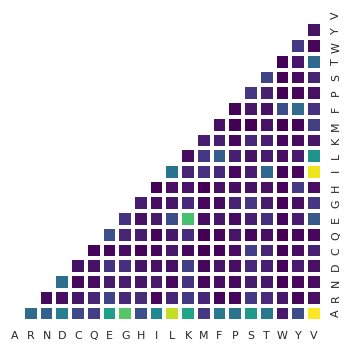

In [79]:
sns.set_theme(style='white')
f, ax = plt.subplots(figsize=(5,5))

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(matrix, mask=np.fliplr(mask), square=True,
                alpha=1, cmap='viridis',
                linewidths=3, #linecolor='gray',
                xticklabels=amino_acids,
                yticklabels=amino_acids[::-1],
                cbar=False,
               )

g.yaxis.tick_right()
#g.yaxis.set_label_position('right')
g.tick_params(right=False)

# for edge, spine in ax.spines.items():
#     spine.set_visible(True)

# m = pd.DataFrame(matrix)
# for i, c in enumerate(m.columns):
#     for j, v in enumerate(m[c]):
#         if i + j < 20:
#             continue
#         ax.text(i + 0.5, j + 0.5, '+', size=v/20, ha='center', va='center')
f.tight_layout()
f.savefig('mut_freq.png', dpi=300)